<a href="https://colab.research.google.com/github/mdev-gamma/COMP9444_Group/blob/main/neural_style_transfer_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer
Pytorch implementation of paper **A Neural Algorithm of Artistic Style** - Gatys, Ecker and Bethge 2015

Paper abstract url: https://arxiv.org/abs/1508.06576

Paper url: https://arxiv.org/pdf/1508.06576

Code adapted from https://github.com/yunjey/pytorch-tutorial/blame/master/tutorials/03-advanced/neural_style_transfer/main.py

Using VGG19, five convolution layers are selected for calculation of loss $L_{content}$  and $L_{style}$. Note for calculation of $L_{total}$ this implementation only uses one weighting factor $\beta$. Also does uses a clone of the content image instead of random noise.

In [2]:
%%capture
!pip install datasets

In [3]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/neural_style_transfer/main.py
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
from datasets import load_dataset, load_from_disk

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def load_image(image, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    # image = Image.open(image_path)

    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)

    return image.to(device)


In [6]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features

    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


In [7]:
def main(config):

    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

    # Load content and style images
    # Make the style image same size as the content image
    content = load_image(config.content, transform, max_size=config.max_size)
    style = load_image(config.style, transform, shape=[content.size(2), content.size(3)])

    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)

    optimizer = torch.optim.Adam([target], lr=config.lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()

    for step in range(config.total_step):

        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w)

        # Compute total loss, backprop and optimize
        loss = content_loss + config.style_weight * style_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % config.log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}'
                   .format(step+1, config.total_step, content_loss.item(), style_loss.item()))

        if (step+1) % config.sample_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, f'{config.output_dir}/output-{step+1}.png')


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--content', type=str, default='png/content.png')
#     parser.add_argument('--style', type=str, default='png/style.png')
#     parser.add_argument('--max_size', type=int, default=400)
#     parser.add_argument('--total_step', type=int, default=2000)
#     parser.add_argument('--log_step', type=int, default=10)
#     parser.add_argument('--sample_step', type=int, default=500)
#     parser.add_argument('--style_weight', type=float, default=100)
#     parser.add_argument('--lr', type=float, default=0.003)
#     config = parser.parse_args()
#     print(config)
#     main(config)

In [13]:
import os
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')
source = "/content/drive/MyDrive/COMP9444_Project/datasets"
os.chdir(source)

Mounted at /content/drive/


In [14]:
style_ds = load_dataset("style")
content_ds = load_from_disk("content/sample")
content_image = content_ds[2]["image_path"]
style_image = style_ds["train"][0]["image"]


In [15]:
from dataclasses import dataclass
@dataclass
class Config:
  content: Image
  style: Image
  output_dir: str
  max_size: int
  total_step: int
  log_step: int
  sample_step: int
  style_weight: float
  lr: float

In [16]:
config = Config(content_image, style_image, "/content/drive/MyDrive/COMP9444_Project/sample_output", 400,2000,10,500,100, 0.003)

In [17]:
main(config)

<ipython-input-5-01fed581adf8>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step [10/2000], Content Loss: 6.7237, Style Loss: 217.4089
Step [20/2000], Content Loss: 12.3287, Style Loss: 157.1713
Step [30/2000], Content Loss: 15.1912, Style Loss: 125.6718
Step [40/2000], Content Loss: 17.0254, Style Loss: 107.1456
Step [50/2000], Content Loss: 18.3537, Style Loss: 94.9953
Step [60/2000], Content Loss: 19.3734, Style Loss: 86.2741
Step [70/2000], Content Loss: 20.1804, Style Loss: 79.6587
Step [80/2000], Content Loss: 20.8403, Style Loss: 74.4170
Step [90/2000], Content Loss: 21.4079, Style Loss: 70.0691
Step [100/2000], Content Loss: 21.9048, Style Loss: 66.3924
Step [110/2000], Content Loss: 22.3524, Style Loss: 63.2167
Step [120/2000], Content Loss: 22.7597, Style Loss: 60.4311
Step [130/2000], Content Loss: 23.1240, Style Loss: 57.9707
Step [140/2000], Content Loss: 23.4508, Style Loss: 55.7565
Step [150/2000], Content Loss: 23.7534, Style Loss: 53.7468
Step [160/2000], Content Loss: 24.0323, Style Loss: 51.9053
Step [170/2000], Content Loss: 24.2880, Style 

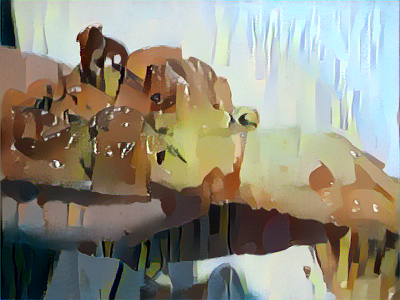

In [18]:
Image.open(f"{config.output_dir}/output-2000.png")


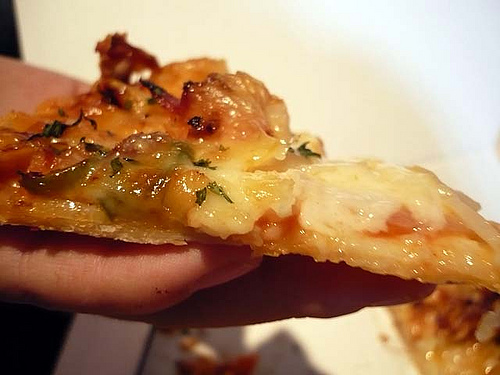

In [19]:
content_image

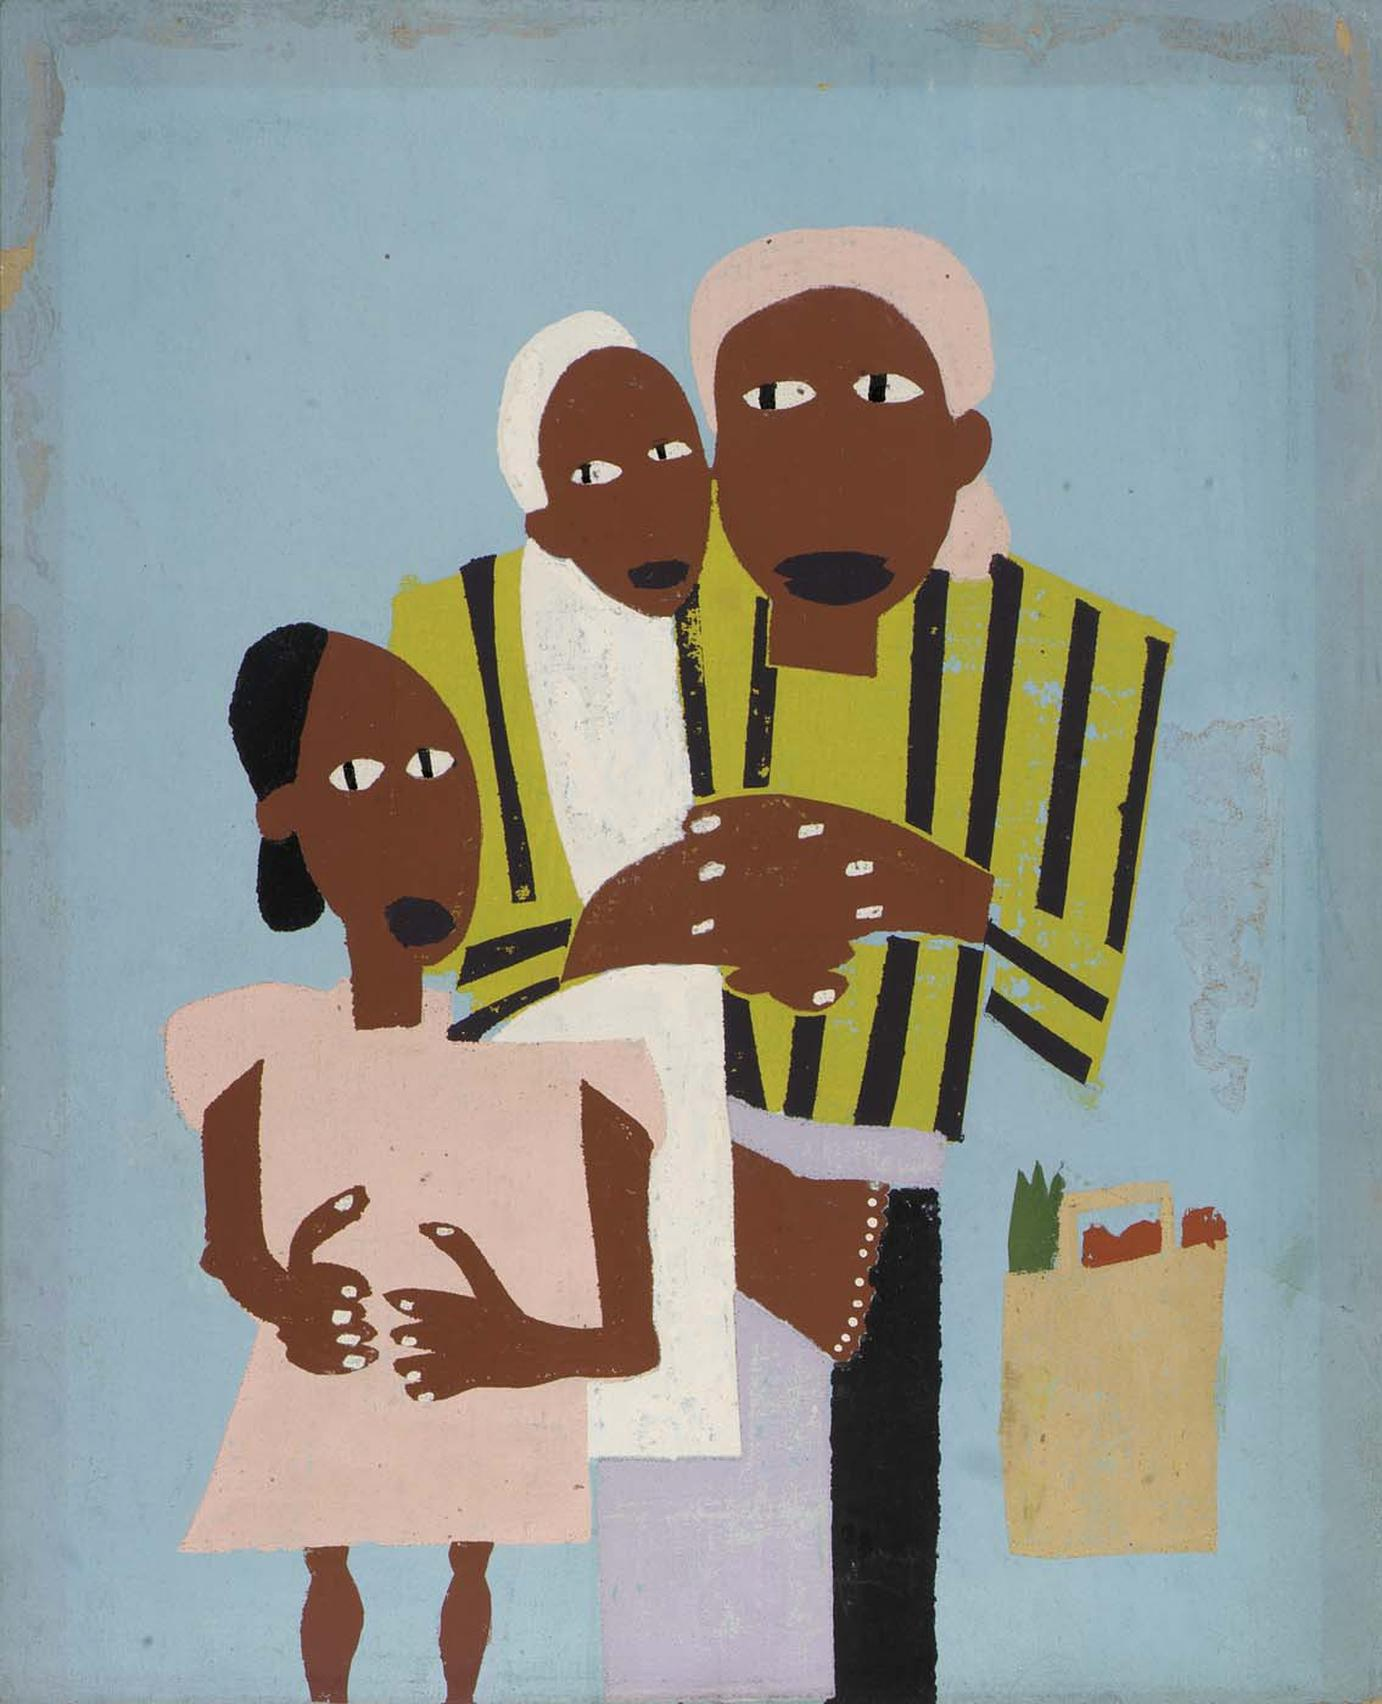

In [ ]:
style_image